<div align="center">

# Demonstration of two different a posteriori error analyses for a non-standard quantity of interest


## Authors: Zachary D Stevens and Jehanzeb Chaudhry
    
#### Department of Mathematics and Statistics
#### University of New Mexico
    
    
### Research supported by NSF grant #1720402





This notebook numerically illustrates the a posteriori estimates derived in the work:


<a id="1"></a> 
Chaudhry, Estep, Stevens, Tavener. Error estimation and uncertainty quantification for first time to athreshold value (2020)

The error estimates are for ODEs of the form

$$ \dot{y} = f(y,t) $$

Given a functional $S(y(t))$ and a threshold value $R$, the non-standard quantity of interest takes the form

$$Q(y) =\min_{t\in[t_0,T]} arg\left( S(y(t))=R\right) $$

The ODE is solved using two methods; cG(1) and Crank-Nicolson. Let $Y(t)$ denote a numerical solution. This notebook implements the three methods detailed in the above reference to estimate the error $Q(y)-Q(Y)$. The first method utilizes Taylor's theorem while the other methods use root-finding schemes. All three methods require certain adjoint problems to be solved.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from NSQoI_and_error_functions import *
import scipy.optimize as opt

In [2]:
###Initialize problem and discretization
q=1      #Degree of cG(q) forward solver
t0=0     #initial time
T=1      #final time
y0=1.    #initial condition
F=lambda t: np.sin(2*np.pi*t)  #RHS function of ode in form y'=f(t)y. Used in the cG(q) solver.
F_CN=lambda t,y: np.sin(2.*np.pi*t)*y  #RHS function of ode in form y'=f(t,y). Used in the Crank-Nicolson solver.


##Set up QoI
##the functional is S(y(t))=y(t)
R=1.3 #threshold value


##True, analytic solution and QoI
y_true= lambda x: np.exp((1/(2*np.pi))*(1.-np.cos(2*np.pi*x)))
true_time=np.arccos(-2*np.pi*np.log(R)+1)/(2*np.pi)


#Set up Adjoint problem
q2=q+2              #Degree of cG(q2) adjoint solver
N=100 #number of sub-intervals for adjoint solver
phi0=1.             #Initial value of Adjoint
F_Adj=lambda X: -np.sin(2*np.pi*X) #RHS of adjoint problems

In [3]:
### CG(q) solution and grid

M=40                    #number of sub-intervals for cG(q) solver
t=np.linspace(t0,T,M+1) #time-grid
Y=solve_lin(y0,F,t,q)   #solve using cG(q)

##Compute QoI and determine surrounding nodes/function values.
##The nodes/values are needed for the root-finding methods.
##example of notation: Y(tL)=YL and tL is the NL-th node in the time-grid.
[YL,Y1,Y2,YR,NL,N1,N2,NR,tL,t1,t2,tR,num_time]=window_numtime(Y,t,q,R)

#numerical QoI
print('Q(Y)=',num_time)

#Get True Error in QoI
error_true = true_time - num_time

Q(Y)= 0.3626248878663315


In [4]:
### Crank-Nicolson (C-N) solution and grid

M=20                      #number of sub-intervals for C-N solver
t=np.linspace(t0,T,M+1)   #time-grid
Y=solve_CN_1D(y0,t,F_CN)  #solve using C-N


##Compute QoI and determine surrounding nodes/function values.
##The nodes/values are needed for the root-finding methods.
##example of notation: Y(tL)=YL and tL is the NL-th node in the time-grid.
[YL,Y1,Y2,YR,NL,N1,N2,NR,tL,t1,t2,tR,num_time]=window_numtime(Y,t,q,R)

#numerical QoI
print('Q(Y)=',num_time)

#Get True Error in QoI
error_true = true_time - num_time

Q(Y)= 0.3663158720815092


In [5]:
### Error Estimate: Taylor Series method.

print('true error',error_true)

tadj=np.linspace(num_time,t0,N+1) #grid for adjoint problem
adj=solve_lin(phi0,F_Adj,tadj,q2) #solve adjoint problem

E=get_err_lin(Y,adj[::-1],F,q,q2,t,tadj[::-1])[0] #Term required for overall error
jac=F(num_time) #jacobian, w.r.t 'y', of RHS=F(t)y
est=-E/(jac*E+F(num_time)*R) #error formula
print('estimate',est)
print('effect',est/error_true)

true error -0.004017688932066776
estimate -0.004056579230855135
effect 1.009679768505212


In [6]:
### Secant method with corrected nodes:
#Finds root of a function g=Y+e-R. The first root of this function is equal to the true QoI: Q(y).
#where Y=numerical solution, e=Y-y (error in numerical solution), R=threshold-value


### Secant method requires two initial points. Use x0,x1 such that x0 <Q(Y)< x1
x0=t1
x1=t2
func=lambda x:evalfunc(Y,t,q,x) #interpolate 'Y' between grid nodes

##Use adjoint-based error formulas to get corrected function values: 
#error at left point:
t1phi=np.linspace(x0,t0,N+1) #grid
phi1=solve_lin(phi0,F_Adj,t1phi,q2) #adjoint solution
E0=get_err_lin(Y,phi1[::-1],F,q,q2,t,t1phi[::-1])[0] #error

#error at right point:
t2phi=np.linspace(x1,t0,N+1) #grid 
phi2=solve_lin(phi0,F_Adj,t2phi,q2) #adjoint solution
E1=get_err_lin(Y,phi2[::-1],F,q,q2,t,t2phi[::-1])[0] #error

#corrected function values:Y+e
a0=func(x0)+E0
a1=func(x1)+E1

#tolerance for secant method
tol=10**(-12)

#initialize
y_error=1.
counter=0

while y_error>tol:
    if counter == 100:#cap on number of iterations
        print('did not converge')
        break
    x2=sec_method_step(a0,a1,x0,x1,R) #one step of secant method
    
    #find error in Y at resulting point 'x2'
    tphi=np.linspace(x2,t0,101) #grid
    phi=solve_lin(phi0,F_Adj,tphi,q2) #adjoint solution 
    E2=get_err_lin(Y,phi[::-1],F,q,q2,t,tphi[::-1])[0] #error
    a2=func(x2)+E2 #corrected function value Y+e
    
    #update for next iteration
    y_error=abs(a2-R)
    a0=a1
    a1=a2
    x0=x1
    x1=x2
    
    counter+=1
    
print('corrected time value')
print(x2)
print('Estimated error in QoI')
print(x2-num_time)
print('secant method effectivity')
print((x2-num_time)/error_true)
print('Number of Adjoints needed')
print(counter+2)#add 2 for the initial 2 before starting iterations

corrected time value
0.36229818314944967
Estimated error in QoI
-0.004017688932059504
secant method effectivity
0.99999999999819
Number of Adjoints needed
7


In [7]:
### Inverse quadratic interpolation method with corrected nodes:
#Finds root of a function g=Y+e-R. The first root of this function is equal to the true QoI: Q(y).
#where Y=numerical solution, e=Y-y (error in numerical solution), R=threshold-value


### Inverse quadratic interpolation method requires three initial points. Use x0,x1 such that x0 <x1<Q(Y)< x2

x0=tL
x1=t1
x2=t2
func=lambda x:evalfunc(Y,t,q,x) #interpolate 'Y' between grid nodes

##Use adjoint-based error formulas to get corrected function values: 
#error at first point x0
tLphi=np.linspace(x0,t0,N+1) #grid 
phiL=solve_lin(phi0,F_Adj,tLphi,q2) #solution to adjoint
E0=get_err_lin(Y,phiL[::-1],F,q,q2,t,tLphi[::-1])[0] #error

#error at second point x1
t1phi=np.linspace(x1,t0,N+1) #grid 
phi1=solve_lin(phi0,F_Adj,t1phi,q2) #solution to adjoint
E1=get_err_lin(Y,phi1[::-1],F,q,q2,t,t1phi[::-1])[0] #error

#error at third point x2
t2phi=np.linspace(x2,t0,N+1) #grid 
phi2=solve_lin(phi0,F_Adj,t2phi,q2) #solution to adjoint
E2=get_err_lin(Y,phi2[::-1],F,q,q2,t,t2phi[::-1])[0] #error


#Corrected function values: Y+e
a0=func(x0)+E0
a1=func(x1)+E1
a2=func(x2)+E2


#tolerance for inverse quad. method
tol=10**(-12)

#initialize
y_error=1.
counter=0

while y_error>tol:
    if counter == 100:#cap on number of iterations
        print('did not converge')
        break
    x3=inv_quad_step(a0,a1,a2,x0,x1,x2,R) #one step of inverse quad. method
    
    #find error in Y at resulting point x3
    tphi=np.linspace(x3,t0,N+1) #grid
    phi=solve_lin(phi0,F_Adj,tphi,q2) #solution to adjoint
    E3=get_err_lin(Y,phi[::-1],F,q,q2,t,tphi[::-1])[0] #error
    a3=func(x3)+E3 #corrected function value: Y+e
    
    #update for next iteration
    y_error=abs(a3-R)
    a0=a1
    a1=a2
    a2=a3
    x0=x1
    x1=x2
    x2=x3
    counter+=1
    
print('corrected time value')
print(x3)
print('error in QoI')
print(x3-num_time)
print('inverse quadratic method effectivity')
print((x3-num_time)/error_true)
print('Number of Adjoints Needed')
print(counter+3)#add 3 for the initial 3 before starting iterations

corrected time value
0.3622981831494497
error in QoI
-0.004017688932059449
inverse quadratic method effectivity
0.9999999999981762
Number of Adjoints Needed
7


NameError: name 'dense' is not defined

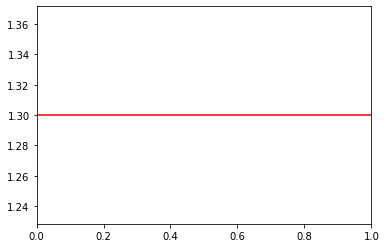

In [8]:
#Graph the true values of the functional S(y(t))=y(t) along with the threshold value R and the QoI Q(Y)=min{t:S(y(t))=R}

dense_grid=np.linspace(t0,T,500)
plt.axhline(y=R, color = 'red')
plt.plot(dense,y_true(dense_grid))
plt.axvline(x=true_time, color = 'green')

plt.xlabel('t')
plt.ylabel('S(y(t))')

plt.legend(['R','S(y(t))','Q(y)'])


In [ ]:
#close up comparing the numerical functional S(Y(t)) and numerical QoI Q(Y) with the true functional S(y(t)) and the true QoI Q(y)

dense=np.linspace(t0,T,500)
plt.axhline(y=R, color = 'red')
plt.plot(dense,y_true(dense),color='blue')
plt.axvline(x=true_time, color = 'green')
plt.plot(t,Y,linestyle='dashed',color='blue')
plt.axvline(x=num_time, linestyle='dashed',color = 'green')
plt.xlabel('t')
plt.ylabel('S(y(t))')
plt.legend(['R','S(y(t))','Q(y)','S(Y(t))','Q(Y)'])
plt.ylim(1.295,1.305)
plt.xlim(0.36,0.37)
